In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from region_new import Region, emission_simple
from lclu.constant import lcz_cmap, lcz_hight

In [14]:
import os
import json
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import shapely.geometry 

In [4]:
# bounding boxes
bounding_box = json.load(open('bounding_box.json'))

In [5]:
# census data
tk_cen_path = os.path.join("data","census","tk_summary.xlsx")
za_cen_path = os.path.join("data","census","za_summary.xlsx")
eg_cen_path = os.path.join("data","census","eg_summary.xlsx")

tk_cen = pd.read_excel(tk_cen_path, "mean")
za_cen = pd.read_excel(za_cen_path, "mean")
eg_cen = pd.read_excel(eg_cen_path, "mean") 
tk_cen = tk_cen.groupby(["region","city","year"]).mean().reset_index()
# we only take the most recent year
tk_cen = tk_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(tk_cen, on=["region","city","year"])
eg_cen = eg_cen.groupby(["region","city"], sort=False)['year'].max().reset_index().merge(eg_cen, on=["region","city","year"])

# tk_cen.loc[tk_cen["city"]=='Altınordu', "city"] = "Merkez"
# tk_cen.loc[tk_cen["city"]=='Ortahisar', "city"] = "Merkez"
tk_cen.loc[tk_cen["city"]=='Yunusemre', "city"] = "Merkez"
za_cen = za_cen.groupby(["region","city","year"]).mean().reset_index()
eg_cen = eg_cen.groupby(["region","city","year"]).mean().reset_index()

In [6]:
# house data
ordu_house = os.path.join("data","clipped_house","Ordu_house.pkl")
johannesburg_house = os.path.join("data","clipped_house","Johannesburg_house.pkl")
cairo_house = os.path.join("data","clipped_house","Cairo_house.pkl")
manisa_house = os.path.join("data","clipped_house","Manisa_house.pkl")
adana_house = os.path.join("data","clipped_house","Adana_house.pkl")
trabzon_house = os.path.join("data","clipped_house","Trabzon_house.pkl")

In [7]:
# lcz data
lcz_path = os.path.join ('data','lcz','lcz_filter_v1.tif')
lst_path = os.path.join ('data','lst','')
ntl_path = os.path.join ('data','ntl','ntl_avg_2101.tif')


In [8]:
pop_path = os.path.join('data', 'pop', '')

In [11]:
cities = dict(
    Ordu = dict(
        box= bounding_box["Ordu"]["box"],
        fua= bounding_box["Ordu"]["fua"],
        level = "NAME_2",
        name = "Ordu",
        house = ordu_house,
        census = tk_cen
    ),
    Manisa = dict(
        box= bounding_box["Manisa"]["box"],
        fua= bounding_box["Manisa"]["fua"],
        level = "NAME_2",
        name = "Manisa",
        house = manisa_house,
        census = tk_cen,
       
    ),
    Adana = dict(
        box= bounding_box["Adana"]["box"],
        fua= bounding_box["Adana"]["fua"],
        level = "NAME_2",
        name = "Adana",
        house = adana_house,
        census = tk_cen,
        
    ),
    Trabzon = dict(
        box= bounding_box["Trabzon"]["box"],
        fua= bounding_box["Trabzon"]["fua"],
        level = "NAME_2",
        name = "Trabzon",
        house = trabzon_house,
        census = tk_cen,
     
    ),
    Cairo = dict(
        box= bounding_box["Cairo"]["box"],
        fua= bounding_box["Cairo"]["fua"],
        level = "NAME_2",
        name = "Cairo",
        house = cairo_house,
        census = eg_cen,
    ),
    Johannesburg = dict(
        box= bounding_box["Johannesburg"]["box"],
        fua= bounding_box["Johannesburg"]["fua"],
        level = "NAME_2",
        name = "Johannesburg",
        house = johannesburg_house,
        census = za_cen,
    ),
)

In [17]:
Cities = {}
# resolution = (-500, 500)
resolution = (-100, 100)
for index, (key, val) in enumerate(cities.items()):
    print(key)
    box, fua, level, name, house, census = val["box"], val["fua"], val["level"],val["name"],val["house"],val["census"]
    fua = shapely.geometry.Polygon(fua)
    fua = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[fua])
    city = Region(val["box"])
    if name != "Ordu":
        continue
    
    city.add_layer(layer_name="fua", 
                   geo_data=fua, 
                   layer_type="vector", 
                   box=box, 
                   level=None, 
                   meta="Functional Urban Area")
    # add MS building
    house = pickle.load(open(house,"rb"))
    
    
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
    city.add_layer(layer_name="pop",
                   geo_data=pop_path+name+'.tif',
                   layer_type='raster',
                   box=box,
                   var_name="pop",
                   meta='population'
                   )
    # add lcz raster layer
    city.add_layer(layer_name="lcz", 
                   geo_data=lcz_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="lcz", 
                   meta="LCZ categorey label")
    #  add lst raster layer
    city.add_layer(layer_name="lst", 
                   geo_data=lst_path+name+'_2021_1.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="lst", 
                   meta="LST")
    # add ntl raster layer
    city.add_layer(layer_name="ntl", 
                   geo_data=ntl_path, 
                   layer_type="raster", 
                   box=box, 
                   var_name="ntl", 
                   meta="Nighttime Light")
    
    
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=resolution, 
                                new_name = "MS_raster_100",
                                res_type="meter")
    
    #unify the projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster_100", 
                    raster_list={
                        "lcz":(["lcz"],"nearest"),
                        "lst":(["lst"],"linear"),
                        "ntl":(["ntl"],"linear"),
                        "pop":(["pop"], "linear")
                        }
                    )
    # height = np.vectorize(lcz_hight.get)(city.output.lcz_height.data)
    # height[height == None] = 0
    # city.output.lcz_height.data = height.astype(float)
    
    # estiamte co2 emission with simple function
    #city.output = city.output.assign(emission = emission_simple)
    Cities[key] = city                                                                                  

Ordu


/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/home/matt/.local/lib/python3.10/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be remove

<xarray.Dataset>
Dimensions:      (band: 1, x: 338, y: 125)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 37.79 37.79 37.79 37.79 ... 38.08 38.08 38.08 38.08
  * y            (y) float64 41.03 41.03 41.03 41.03 ... 40.92 40.92 40.92 40.92
    spatial_ref  int64 0
Data variables:
    pop          (band, y, x) float64 ...
<xarray.Dataset>
Dimensions:      (band: 1, x: 328, y: 121)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 37.79 37.79 37.79 37.79 ... 38.08 38.08 38.08 38.08
  * y            (y) float64 41.03 41.03 41.03 41.03 ... 40.92 40.92 40.92 40.92
    spatial_ref  int64 0
Data variables:
    lcz          (band, y, x) uint8 ...
<xarray.Dataset>
Dimensions:      (band: 2, x: 34, y: 13)
Coordinates:
  * band         (band) int64 1 2
  * x            (x) float64 37.79 37.8 37.81 37.81 ... 38.06 38.07 38.08 38.08
  * y            (y) float64 41.03 41.02 41.01 41.0 ... 40.95 40.94 40.93 40.92
    spatial_ref  int64 0
Data variabl

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [32]:
# dump city
dump_path = os.path.join("data","Cities_v1_rasters_only.pickle")
with open(dump_path,"wb") as f:
    pickle.dump(Cities, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# load city
dump_path = os.path.join("data","Cities_v1_rasters_only.pickle")
with open(dump_path, 'rb') as f:
    Cities = pickle.load(f)

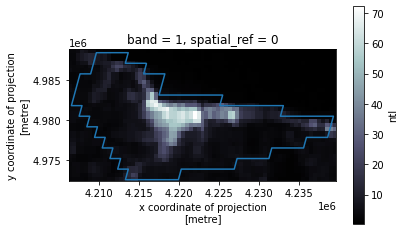

In [27]:
ax = Cities['Ordu'].vector['fua'].geo_df.boundary.plot()
Cities['Ordu'].raster['ntl'].tiff.ntl.plot(cmap='bone', ax=ax)

In [24]:
def compare_rasters(cities, rasters_list):
    couples = [(r1, r2) for idx, r1 in enumerate(rasters_list) for r2 in rasters_list[idx + 1:]]
    for city in cities:
        cities[city].normalize_output()
        for couple in couples:
            r1, r2 = couple
            plt.figure()
            print(city+" "+r1+" "+r2)
            cities[city].difference_map(r1, r2)

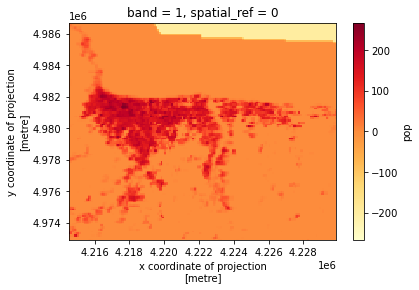

In [29]:
Cities['Ordu'].output.pop.plot(cmap='YlOrRd')

Ordu lst ntl
Ordu lst pop
Ordu ntl pop


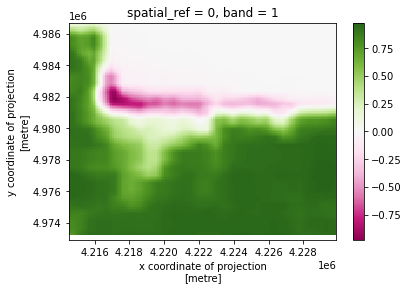

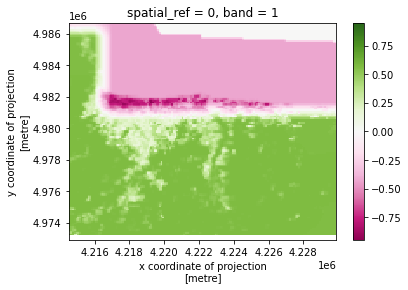

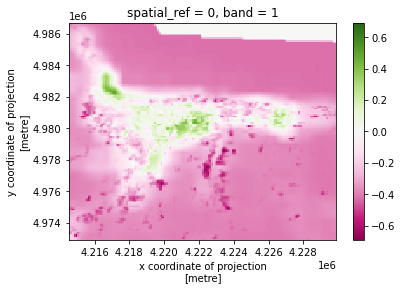

In [30]:
rasters_list = ["lst", "ntl", "pop"]
compare_rasters(Cities, rasters_list)

Purple areas correspond to population clusters with low NTL and Green areas to high NTL clusters with a lower population density. Thus, seems interesting to combine the two parameters.
LST has a coarser resolution and does not bring this much information for Ordu (See below)

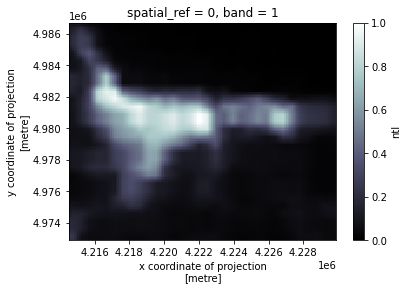

In [26]:
city = Cities['Ordu']
city.normalize_output()
city.output_normed.ntl.plot(cmap='bone')

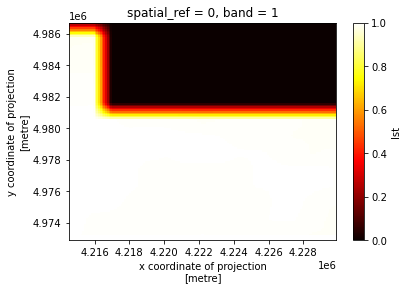

In [27]:
city.output_normed.lst[0].plot(cmap='hot')